<a href="https://colab.research.google.com/github/relew/matchPrediction/blob/master/away_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import pickle

# importing the models
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBRegressor
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score


# addition predifined 'functions' for splitting the data and evaluating the model
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import RandomizedSearchCV

import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', 100)

import xgboost as xgb
xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=42)


from xgboost import XGBClassifier


# Support functions

In [2]:
class match_support_functions():
        
    def categorical_to_numerical_convert(self,df,cat_columns):

        for column in cat_columns:
            one_hot = pd.get_dummies(df[column])
            # Drop column as it is now encoded
            df = df.drop(column,axis = 1)
            # Join the encoded df
            df = df.join(one_hot)

        return df

    def IQR_outlier_treatment(self,df, datacolumn, V1 , V3):
        
        print(datacolumn,V1,V3)

        Q1,Q3 = np.percentile(df[datacolumn] , [V1,V3])
        IQR = Q3 - Q1
        lower_range = Q1 - (1.5 * IQR)
        upper_range = Q3 + (1.5 * IQR)

        #print(f'{datacolumn} minimum range:',lower_range)
        #print(f'{datacolumn} maximum range:',upper_range) 
        df = df[(df[datacolumn] > lower_range) & (df[datacolumn] < upper_range)]
        
        return df
        
    def get_top_correlation(self,df):
        cor = df.corr().abs()
        cor2 = cor.unstack()
        cor3 = cor2.sort_values(kind="quicksort", ascending = False)

        return pd.DataFrame(cor3)

    def evaluate_prediction(self,y_prediction,y_val):
        
        mse = mean_squared_error(y_val, y_prediction)
        rmse = mean_squared_error(y_val, y_prediction, squared=False)
        rx = r2_score(y_val, y_prediction)
        print('model mean squared error:',mse)
        print('model root mean squared error:',rmse)
        print('model R2:',rx)


    def try_models(self,model_type,X_train,y_train,X_val,y_val):
        model = model_type
        model.fit(X_train, y_train)
        print('='*20)
        print(f'{model_type}')
        print(f'accuracy of train set: {model.score(X_train, y_train)}')
        print(f'accuracy of val set: {model.score(X_val, y_val)}')
        y_prediction = model.predict(X_val)
        self.evaluate_prediction(y_prediction,y_val)
        
        return model
    

# Script starts here

In [3]:
#df = pd.read_csv("match_data.csv")
#df.head()

In [5]:
url = 'http://dataevents.hu/202303/filedataevents/competition_table.xlsx'
df = pd.read_excel(url)

# Feature Engineering

In [7]:
df["away_win_expected"] = np.where((df["odds_away_team_win"] < df["odds_draw"]) & 
                                   (df["odds_away_team_win"] < df["odds_home_team_win"]),1,0)

In [8]:
df['home_win_prob'] = np.where( 1/df['odds_home_team_win'] > 1 ,1 ,1/df['odds_home_team_win'])
df['draw_prob'] = np.where( 1/df['odds_draw'] > 1 ,1 ,1/df['odds_draw'])

# Added metrics

In [10]:
# good 67.42
df["home_team_roll4_points_diff"] = df["home_team_point_roll4_sum"]-df["home_team_expected_point_roll4_sum"]
df["away_team_roll4_points_diff"] = df["away_team_point_roll4_sum"]-df["away_team_expected_point_roll4_sum"]
# good 67.46
df["home_team_roll1_points_diff"] = df["home_team_point_roll1_sum"]-df["home_team_expected_point_roll1_sum"]
df["away_team_roll1_points_diff"] = df["home_team_point_roll1_sum"]-df["home_team_expected_point_roll1_sum"]

# extra
df["home_team_all_points_diff"] = df["home_team_point_mean"]-df["home_team_expected_point_mean"]
df["away_team_all_points_diff"] = df["away_team_point_mean"]-df["away_team_expected_point_mean"]
df["home_s_p1"] = np.where(df["home_team_match_nr"]<19,1,0)
df["home_s_p2"] = np.where(df["home_team_match_nr"]>=19,1,0)

df["away_s_p1"] = np.where(df["away_team_match_nr"]<19,1,0)
df["away_s_p2"] = np.where(df["away_team_match_nr"]>=19,1,0)

# sample prepare

In [18]:
### Train

data = df.copy()

data_y1= data[data['away_win_flag']==1].reset_index(drop=True)
data_y0= data[data['away_win_flag']==0].reset_index(drop=True)

#selectiong train features(X_train) and train targets(y_train)
# train_feature = ['div_season_home_acc','home_win_prob',
#                  'home_team_match_nr','home_team_goal_roll4_sum','home_team_opponents_goal_roll4_sum',
#                  'home_team_point_roll4_sum','home_team_expected_point_roll4_sum',
#                  'home_team_goal_roll1_sum','home_team_opponents_goal_roll1_sum',
#                  'home_team_point_roll1_sum','home_team_expected_point_roll1_sum',
#                  'away_team_match_nr','away_team_goal_roll4_sum','away_team_opponents_goal_roll4_sum',
#                  'away_team_point_roll4_sum','away_team_expected_point_roll4_sum',
#                  'away_team_goal_roll1_sum','away_team_opponents_goal_roll1_sum',
#                  'away_team_point_roll1_sum','away_team_expected_point_roll1_sum']


train_feature = ['home_win_prob',
                 'home_team_opponents_goal_roll4_sum',
                 'home_team_point_roll4_sum','home_team_expected_point_roll4_sum',
                 'away_team_goal_roll4_sum','away_team_opponents_goal_roll4_sum',
                 'away_team_point_roll4_sum','away_team_expected_point_roll4_sum',
                 'home_team_roll4_points_diff','away_team_roll4_points_diff',
                 'home_team_roll1_points_diff','away_team_roll1_points_diff',
                 'home_s_p1','home_s_p2',
                 'away_s_p1','away_s_p2']

train_target = 'away_win_flag'

### Train
data_to_train = pd.concat([data_y1[0:15000],data_y0[0:15000]], ignore_index=True)
X_train = data_to_train[train_feature].values
y_train = data_to_train[train_target].values

### Test
data_to_test = pd.concat([data_y1[15000:19000],data_y0[15000:19000]], ignore_index=True)
X_test = data_to_test[train_feature].values
y_test = data_to_test[train_target].values

In [19]:
support_functions = match_support_functions()

In [20]:
data_y1.shape

(19154, 180)

In [21]:
all_cols = df.columns.tolist()
all_cols.remove('match_id')
all_cols.remove('season')
all_cols.remove('div')
all_cols.remove('home_win_flag')
all_cols.remove('draw_flag')
all_cols.remove('away_win_flag')

In [22]:
train_feature = all_cols

best_features = {}
auc_abs_max = 0
test_accuracy_abs_max = 0


for i in range(len(train_feature)-1):
    
    auc_max = 0

    for x in data_to_test[train_feature].columns:

        train_feature_x = [n for n in train_feature if n != x]


        X_train = data_to_train[train_feature_x].values
        y_train = data_to_train[train_target].values

        ### Test
        X_test = data_to_test[train_feature_x].values
        y_test = data_to_test[train_target].values

        print("******  ",x,"  ********")
        model = GaussianNB().fit(X_train,y_train)
        accuracy = model.score(X_test, y_test)
        y_prediction = model.predict_proba(X_test)[:,1]
        data_to_test["pred"] = y_prediction
        auc = roc_auc_score(data_to_test['away_win_flag'],data_to_test['pred'] )
        print("auc:",auc)
        
        if auc > auc_max:

            auc_max = auc
            auc_list = []
            auc_list.append(x)
            auc_list.append(auc)
    
        if auc > auc_abs_max:
        
            auc_abs_max = auc
            best_features["best_auc"] = train_feature_x
            
        if accuracy > test_accuracy_abs_max:
        
            test_accuracy_abs_max = accuracy
            best_features["best_acc"] = train_feature_x
    
    train_feature.remove(auc_list[0])

A streamkimeneten csak az utolsó 5000 sor látható.
******   away_team_opponents_yellow_card_roll3_sum   ********
auc: 0.7598265000000001
******   away_team_opponents_yellow_card_roll4_sum   ********
auc: 0.75941396875
******   away_team_red_card_roll4_sum   ********
auc: 0.7602429375
******   away_team_opponents_red_card_roll1_sum   ********
auc: 0.7600350312499999
******   away_team_opponents_red_card_roll2_sum   ********
auc: 0.7603024375
******   away_team_opponents_red_card_roll3_sum   ********
auc: 0.76034509375
******   away_team_opponents_red_card_roll4_sum   ********
auc: 0.7602668125
******   odds_away_team_win_roll2_mean   ********
auc: 0.759303375
******   odds_away_team_win_roll3_mean   ********
auc: 0.75934725
******   odds_away_team_win_roll4_mean   ********
auc: 0.7584826874999999
******   odds_away_team_draw_roll4_mean   ********
auc: 0.7587295000000001
******   away_team_point_mean   ********
auc: 0.7587249374999999
******   home_s_p1   ********
auc: 0.7603121249999999

# Final Model ( best AUC score)

In [23]:
### Train

data = df.copy()

data_y1= data[data['away_win_flag']==1].reset_index(drop=True)
data_y0= data[data['away_win_flag']==0].reset_index(drop=True)

#selectiong train features(X_train) and train targets(y_train)
# train_feature = ['div_season_home_acc','home_win_prob',
#                  'home_team_match_nr','home_team_goal_roll4_sum','home_team_opponents_goal_roll4_sum',
#                  'home_team_point_roll4_sum','home_team_expected_point_roll4_sum',
#                  'home_team_goal_roll1_sum','home_team_opponents_goal_roll1_sum',
#                  'home_team_point_roll1_sum','home_team_expected_point_roll1_sum',
#                  'away_team_match_nr','away_team_goal_roll4_sum','away_team_opponents_goal_roll4_sum',
#                  'away_team_point_roll4_sum','away_team_expected_point_roll4_sum',
#                  'away_team_goal_roll1_sum','away_team_opponents_goal_roll1_sum',
#                  'away_team_point_roll1_sum','away_team_expected_point_roll1_sum']


train_feature = best_features["best_auc"]

train_target = 'away_win_flag'

### Train
data_to_train = pd.concat([data_y1[0:14000],data_y0[0:14000]], ignore_index=True)
X_train = data_to_train[train_feature].values
y_train = data_to_train[train_target].values

### Test
data_to_test = pd.concat([data_y1[14000:19000],data_y0[14000:19000]], ignore_index=True)
X_test = data_to_test[train_feature].values
y_test = data_to_test[train_target].values

In [24]:
model = support_functions.try_models(GaussianNB(),X_train,y_train,X_test,y_test)

GaussianNB()
accuracy of train set: 0.6639642857142857
accuracy of val set: 0.65
model mean squared error: 0.35
model root mean squared error: 0.5916079783099616
model R2: -0.3999999999999999


In [27]:
with open('away_model.pickle', 'wb') as f:
    pickle.dump(model, f)

In [28]:
y_prediction = model.predict_proba(X_test)[:,1]
data_to_test["pred"] = y_prediction
auc = roc_auc_score(data_to_test['away_win_flag'],data_to_test['pred'] )
print("auc:",auc)

auc: 0.7229624000000001


Text(91.68, 0.5, 'Actual')

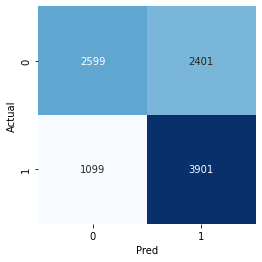

In [32]:
mat = confusion_matrix(data_to_test["away_win_flag"],
                       (data_to_test["pred"] > 0.5).astype(int))
labels = ['0', '1']
 
sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False, cmap='Blues',
            xticklabels=labels, yticklabels=labels)

plt.xlabel('Pred')
plt.ylabel('Actual')